In [ ]:
# https://mp.weixin.qq.com/s/o1VKko4Nkp56NflDg8-x1A
# 我们假设天气、节假日和促销都会影响每天的销售量，并且销售量具有一定的周期性（如每月的波动）。

import pandas as pd
import numpy as np
import random

# 生成日期范围
dates = pd.date_range(start='2022-01-01', periods=1000, freq='D')

# 模拟销售量数据，假设其具有周期性和随机波动
np.random.seed(42)
sales = 200 + 10 * np.sin(np.arange(len(dates)) / 30) + np.random.normal(0, 20, len(dates))

# 随机生成天气、节假日和促销数据
weather = np.random.choice(['Sunny', 'Rainy', 'Cloudy'], size=len(dates))
holiday = np.random.choice([0, 1], size=len(dates), p=[0.9, 0.1]) # 10% 是节假日
promotion = np.random.choice([0, 1], size=len(dates), p=[0.8, 0.2]) # 20% 有促销活动

# 创建DataFrame
df = pd.DataFrame({
    'Date': dates,
    'Sales': sales,
    'Weather': weather,
    'Holiday': holiday,
    'Promotion': promotion
})

# 显示前几行数据
df.head()

'''
在这个数据集中：销售量（Sales） 受月度周期性影响，同时带有随机噪声。天气（Weather） 为一个类别变量，随机生成三种可能的天气：晴天（Sunny）、雨天（Rainy）和多云（Cloudy）。节假日（Holiday） 和 促销（Promotion） 为二值变量，分别表示是否为节假日和是否有促销活动。通过上述步骤，我们生成了一个完整的虚拟销售数据集，包含365天的销售记录。
'''

,Date,Sales,Weather,Holiday,Promotion
0,2022-01-01,209.934283,Cloudy,0,0
1,2022-01-02,197.567986,Sunny,0,0
2,2022-01-03,213.619944,Cloudy,0,0
3,2022-01-04,231.458931,Sunny,0,0
4,2022-01-05,196.646319,Cloudy,0,0


In [3]:
# 日期特征处理
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# 使用独热编码将天气特征转换为数值特征
df = pd.get_dummies(df, columns=['Weather'], drop_first=True)

# 生成滞后特征
for lag in range(1, 8):
 df[f'Sales_lag_{lag}'] = df['Sales'].shift(lag)

# 删除缺失值（由于滞后特征的产生，前几行会产生缺失值）
df = df.dropna()

# 生成滚动窗口的均值和标准差特征
df['Rolling_mean_7'] = df['Sales'].rolling(window=7).mean().shift(1)
df['Rolling_std_7'] = df['Sales'].rolling(window=7).std().shift(1)

# 同样需要删除因滚动窗口导致的缺失值
df = df.dropna()

In [4]:
from sklearn.model_selection import train_test_split
import torch

# 准备训练和测试集
X = df.drop(columns=['Date', 'Sales']).values
y = df['Sales'].values

# 确保没有 NaN
X = np.nan_to_num(X) # 将 NaN 转换为 0 或其他默认数值
y = np.nan_to_num(y)

# 确保数据类型都是数值型
X = X.astype(np.float32)
y = y.astype(np.float32)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 转换为PyTorch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [9]:
import torch.nn as nn

# 定义神经网络模型
class XGBoostTimeSeriesModel(nn.Module):
    def __init__(self, input_dim):
        super(XGBoostTimeSeriesModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 初始化模型
input_dim = X_train.shape[1]
model = XGBoostTimeSeriesModel(input_dim)

In [10]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 模型训练
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

from sklearn.metrics import mean_squared_error

# 模型预测
model.eval()
predictions = model(X_test).detach().numpy()

# 计算均方误差
mse = mean_squared_error(y_test, predictions)
print(f'Test MSE: {mse}')

Epoch 0/500, Loss: 37666.0390625
Epoch 50/500, Loss: 470.25396728515625
Epoch 100/500, Loss: 447.98785400390625
Epoch 150/500, Loss: 422.64312744140625
Epoch 200/500, Loss: 413.9054260253906
Epoch 250/500, Loss: 413.00604248046875
Epoch 300/500, Loss: 411.0451354980469
Epoch 350/500, Loss: 409.2464599609375
Epoch 400/500, Loss: 410.0552062988281
Epoch 450/500, Loss: 419.6650085449219
Test MSE: 383.8683166503906


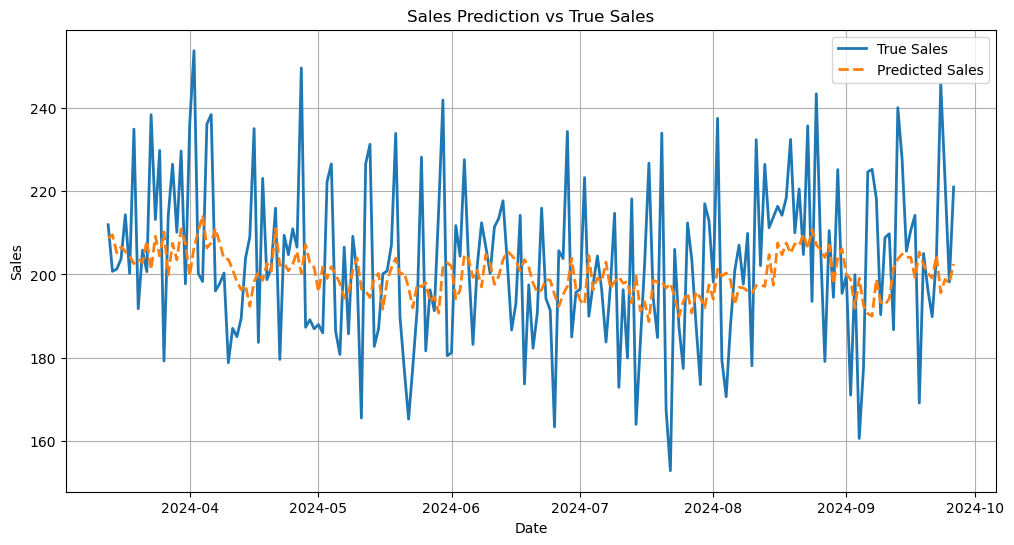

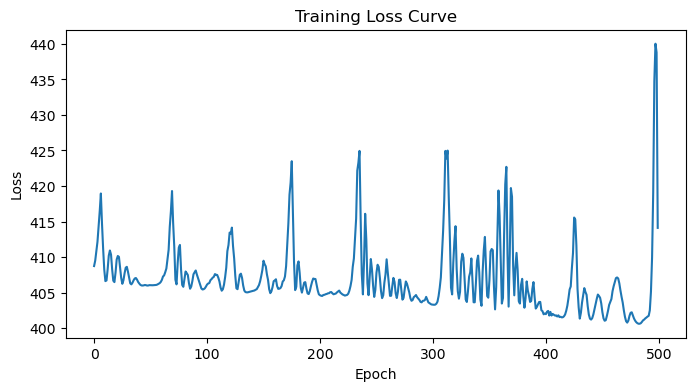

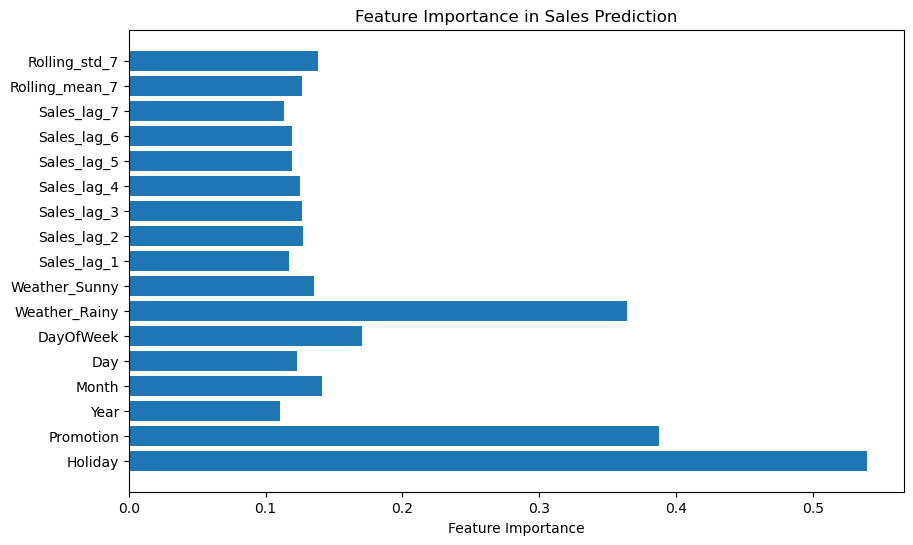

In [11]:
import matplotlib.pyplot as plt

# 绘制预测值与真实值的对比图
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='True Sales', linewidth=2) 
plt.plot(df['Date'][-len(y_test):], predictions, label='Predicted Sales', linestyle='--', linewidth=2) 
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Prediction vs True Sales')
plt.legend()
plt.grid(True)
plt.show()

# 绘制损失下降曲线
losses = []
for epoch in range(epochs):
 model.train()
 optimizer.zero_grad()
 outputs = model(X_train)
 loss = criterion(outputs, y_train)
 loss.backward()
 optimizer.step()
 
 losses.append(loss.item())
 
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

importances = model.fc1.weight.abs().mean(dim=0).detach().numpy()
feature_names = df.drop(columns=['Date', 'Sales']).columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Sales Prediction')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 创建XGBoost模型
xgb_model = xgb.XGBRegressor()

# 定义超参数搜索空间
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# 进行网格搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.5}


In [16]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 创建XGBoost模型
xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300)
# xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

# 定义超参数搜索空间
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# 进行网格搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.5}


In [18]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# 创建XGBoost模型
# xgb_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=5, n_estimators=300)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=True)

# 定义超参数搜索空间
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# 进行网格搜索
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'